# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, cross_validate, TimeSeriesSplit

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, log_loss
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, normalize
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_pickle('FINAL_DATAFRAME.pkl')

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 120)

In [4]:
df.head()

,game_id,home_team,away_team,week,season,home_score,away_score,outcome,spread,total,fav_odds,dog_odds,day/month,time_of_day,month,day,time_day_bin,home_rank,home_wins_into_week,home_losses_into_week,away_rank,away_wins_into_week,away_losses_into_week,home_advantage,game_url,home_score_EMA,home_pt_diff_EMA,home_total_EMA,home_rank_EMA,home_rank_diff_EMA,away_score_EMA,away_pt_diff_EMA,away_total_EMA,away_rank_EMA,away_rank_diff_EMA
0,2009092702,DET,WAS,3,2009,19,14,1.0,-6.0,39.0,-260,220.0,9/27,1.00,9,27,Day,31,0,2,23,1,1,8,http://www.nfl.com/liveupdate/game-center/2009...,19.650,-15.900,47.6375,31.475,18.725,12.800,-1.800,37.0000,20.000,1.775
1,2009092708,TB,NYG,3,2009,0,24,0.0,-6.5,46.0,-270,230.0,9/27,1.00,9,27,Day,28,0,2,2,2,0,26,http://www.nfl.com/liveupdate/game-center/2009...,20.475,-13.000,41.0500,27.575,8.475,28.250,3.900,41.2000,3.000,-13.325
2,2009092707,LA,GB,3,2009,17,36,0.0,-6.5,42.5,-280,240.0,9/27,1.00,9,27,Day,32,0,2,12,1,1,20,http://www.nfl.com/liveupdate/game-center/2009...,3.675,-14.350,38.9000,31.525,13.900,22.575,-0.825,44.3750,11.475,-7.400
3,2009092709,BUF,NO,3,2009,7,27,0.0,-6.0,51.0,-265,225.0,9/27,4.05,9,27,Afternoon,21,1,1,7,2,0,14,http://www.nfl.com/liveupdate/game-center/2009...,28.725,6.350,44.6125,21.000,4.825,46.575,22.200,47.9000,14.850,-2.450
4,2009092710,SEA,CHI,3,2009,19,25,0.0,-3.0,37.5,-155,135.0,9/27,4.05,9,27,Afternoon,22,1,1,14,1,1,8,http://www.nfl.com/liveupdate/game-center/2009...,18.550,6.475,40.2125,14.475,-9.700,16.050,-1.275,42.5375,13.100,6.875


# Prepare data

In [6]:
# drop unnessary rows
df.drop('day/month', axis=1, inplace=True)
df.drop('game_url', axis=1, inplace=True)
df.drop('game_id', axis=1, inplace=True)

In [7]:
df.columns

Index(['home_team', 'away_team', 'week', 'season', 'home_score', 'away_score',
       'outcome', 'spread', 'total', 'fav_odds', 'dog_odds', 'time_of_day',
       'month', 'day', 'time_day_bin', 'home_rank', 'home_wins_into_week',
       'home_losses_into_week', 'away_rank', 'away_wins_into_week',
       'away_losses_into_week', 'home_advantage', 'home_score_EMA',
       'home_pt_diff_EMA', 'home_total_EMA', 'home_rank_EMA',
       'home_rank_diff_EMA', 'away_score_EMA', 'away_pt_diff_EMA',
       'away_total_EMA', 'away_rank_EMA', 'away_rank_diff_EMA'],
      dtype='object')

In [8]:
df = pd.get_dummies(df)

In [55]:
df.reset_index(drop=True, inplace=True)

# Scripts

In [10]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                         model=None,
                         y_true=None,
                         y_proba=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            logloss = log_loss(y_true, y_proba)
            roc_auc = roc_auc_score(y_true, y_proba)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax=sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    
    #scores = pd.DataFrame([model, accuracy, precision, recall, f1_score, logloss, roc_auc]).T
    scores={'model' : model , 'accuracy' : accuracy,
                   'precision':precision,'recall':recall, 'f1':f1_score,
                  'log_loss':logloss, 'ROC-AUC':roc_auc}
    
    
    print(scores)

In [305]:
def make_confusion_matrix_2(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                         model=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            #logloss = log_loss(y_true, y_proba)
            #roc_auc = roc_auc_score(y_true, y_proba)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax=sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    
    #scores = pd.DataFrame([model, accuracy, precision, recall, f1_score, logloss, roc_auc]).T
    scores={'model' : model , 'accuracy' : accuracy,
                   'precision':precision,'recall':recall, 'f1':f1_score}
    
    
    print(scores)

# X and Y data

In [ ]:
# PREPATE X AND Y DATE FOR TRAINING AND TESTING MODELS

In [315]:
#origial x and y data still with test values
X = df.drop(['outcome', 'home_score', 'away_score'], axis=1)
y = np.asarray(df.outcome).reshape(-1, 1)

# test data for final models
x_holdout = X.loc[X.season == 2015]
y_holdout = df.loc[df.season == 2015]['outcome']

# ALL training data. Use with TD grid search and final model testing. 
X_no15 = X.loc[X.season != 2015]
y_no15 = df.loc[df.season != 2015]['outcome']

In [193]:
X_no15.shape

(1504, 94)

In [316]:
#MANUAL TIME SERIES DATA SPLIT
X_val = X_no15.loc[X_no15.season == 2014]
y_train = y_no15.loc[X_no15.season != 2014]
y_val = y_no15.loc[X_no15.season == 2014]

# Scale train/val data
std = StandardScaler()
scaled_x_train = std.fit_transform(X_train)
scaled_x_val = std.transform(X_val)

# scale final train/test data
std_2 = StandardScaler()
scaled_x_train_2 = std_2.fit_transform(X_no15)
scaled_x_val_2 = std_2.transform(X_val)
scaled_x_holdout = std_2.transform(x_holdout)

# LOGISTIC REGRESSION

## baseline

{'model': 'log ts baseline', 'accuracy': 0.6614173228346457, 'precision': 0.6766467065868264, 'recall': 0.7793103448275862, 'f1': 0.7243589743589743, 'log_loss': 0.6369883922331729, 'ROC-AUC': 0.6933881683011704}


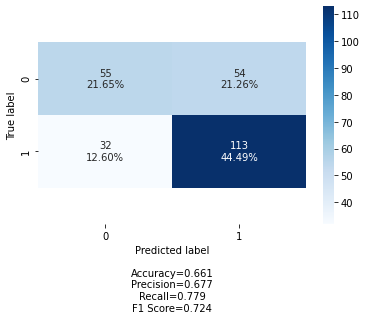

In [31]:
log_mod = LogisticRegression()
log_mod.fit(scaled_x_train, y_train)
preds = log_mod.predict(scaled_x_val)
probs = log_mod.predict_proba(scaled_x_val)

cf = confusion_matrix(y_val, preds)
make_confusion_matrix(cf, model='log ts baseline', y_true = y_val, y_proba=probs[:,1])

## grid search, cross validation

In [108]:
lr_grid = {
    'C':[0.001, 0.01, 0.05, 0.2, 1],
    'solver':["newton-cg", "lbfgs", "liblinear"] 
}

In [334]:
# GRID SEARCH WHILE PRESERVING TIMESERIES CHONOLOGY

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_no15):    
    X_tr, X_val = X_no15.iloc[tr_index], X_no15.iloc[val_index]
    y_tr, y_val = y_no15.iloc[tr_index], y_no15.iloc[val_index]
    
    scaler = StandardScaler()
    scaled_X_tr = scaler.fit_transform(X_tr)
    scaled_X_val = scaler.transform(X_val)
    
    for c in lr_grid['C']:
        for solver in lr_grid['solver']:
            model = LogisticRegression(
            C=c, 
            solver=solver)
            model.fit(scaled_X_tr, y_tr)
            preds = model.predict(scaled_X_val)
            probs = model.predict_proba(scaled_X_val)
            score.append([i,
                          c,
                          solver, 
                          model.score(scaled_X_val, y_val),
                         f1_score(y_val, preds),
                         log_loss(y_val, probs[:,1]),
                         roc_auc_score(y_val, probs[:,1])])
    i += 1

In [335]:
score_log = pd.DataFrame(score, columns=['iter', 'C','solver','accuracy', 'F1','log_loss', 'ROC-AUC'])

In [336]:
score_log.sort_values('accuracy', ascending=False)

,iter,C,solver,accuracy,F1,log_loss,ROC-AUC
47,4,0.001,liblinear,0.708,0.796657,0.623743,0.661673
45,4,0.001,newton-cg,0.692,0.789041,0.618568,0.661598
46,4,0.001,lbfgs,0.692,0.789041,0.618568,0.661598
53,4,0.050,liblinear,0.692,0.781870,0.626970,0.651014
54,4,0.200,newton-cg,0.692,0.780627,0.636665,0.649076
55,4,0.200,lbfgs,0.692,0.780627,0.636684,0.649076
56,4,0.200,liblinear,0.692,0.780627,0.636846,0.648778
58,4,1.000,lbfgs,0.688,0.777143,0.639845,0.649672
48,4,0.010,newton-cg,0.688,0.779661,0.611704,0.652877
49,4,0.010,lbfgs,0.688,0.779661,0.611704,0.652877


{'model': 'Final log test', 'accuracy': 0.6328125, 'precision': 0.6746031746031746, 'recall': 0.6159420289855072, 'f1': 0.6439393939393939, 'log_loss': 0.6511457349919739, 'ROC-AUC': 0.66930729550479}


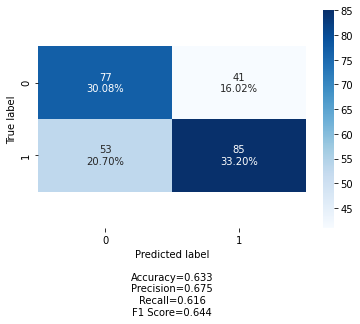

In [112]:
#FINAL TEST ON SCALED HOLDOUT DATA

final_log = LogisticRegression(C=0.001, solver='liblinear')
final_log.fit(scaled_x_train_2, y_no15)
preds = final_log.predict(scaled_x_holdout)
probs = final_log.predict_proba(scaled_x_holdout)

cf = confusion_matrix(y_holdout, preds)
make_confusion_matrix(cf, model='Final log test', y_true = y_holdout, y_proba=probs[:,1])

{'model': 'Final log test', 'accuracy': 0.64453125, 'precision': 0.6424242424242425, 'recall': 0.7681159420289855, 'f1': 0.6996699669966997, 'log_loss': 0.650478078548824, 'ROC-AUC': 0.6712724146401375}


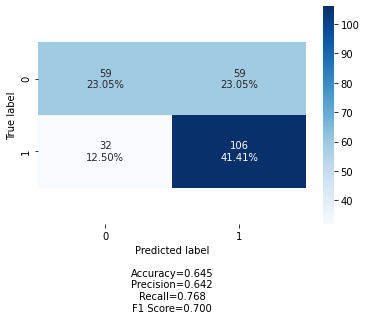

In [351]:
# TESTING NEW MODEL WITH DIFFERENT PARAMETERS

final_log = LogisticRegression(C=0.002, solver='newton-cg')
final_log.fit(scaled_x_train_2, y_no15)
preds = final_log.predict(scaled_x_holdout)
probs = final_log.predict_proba(scaled_x_holdout)

cf = confusion_matrix(y_holdout, preds)
make_confusion_matrix(cf, model='Final log test', y_true = y_holdout, y_proba=probs[:,1])

In [ ]:
# NEXT FEW CELLS ARE JUST FOR SAVING THE RESULTS FOR FURTHER ANALYSIS

In [355]:
data_with_preds = df.loc[df.season == 2015]

In [356]:
data_with_preds.head()

,game_id,home_team,away_team,week,season,home_score,away_score,outcome,spread,total,fav_odds,dog_odds,day/month,time_of_day,month,day,time_day_bin,home_rank,home_wins_into_week,home_losses_into_week,away_rank,away_wins_into_week,away_losses_into_week,home_advantage,game_url,home_score_EMA,home_pt_diff_EMA,home_total_EMA,home_rank_EMA,home_rank_diff_EMA,away_score_EMA,away_pt_diff_EMA,away_total_EMA,away_rank_EMA,away_rank_diff_EMA
521,2015091300,CHI,GB,1,2015,23,31,0.0,-6.5,48.5,-290,245.0,9/13,1.0,9,13,Day,25,5,11,3,12,4,22,http://www.nfl.com/liveupdate/game-center/2015...,20.046104,-7.464868,48.352882,19.341311,2.204589,29.519967,7.519679,50.433305,6.388667,-10.063993
522,2015091306,HOU,KC,1,2015,20,27,0.0,-1.0,40.5,-115,-105.0,9/13,1.0,9,13,Day,20,9,7,14,9,7,6,http://www.nfl.com/liveupdate/game-center/2015...,22.226878,2.321921,43.781994,19.288674,1.065374,22.310142,4.935509,43.712904,13.442637,-2.883897
523,2015091304,BUF,IND,1,2015,27,14,1.0,-1.0,44.5,-120,100.0,9/13,1.0,9,13,Day,18,9,7,4,11,5,14,http://www.nfl.com/liveupdate/game-center/2015...,21.390817,2.772854,43.852494,19.194539,4.368902,26.222663,3.866632,49.216727,8.559040,-9.594800
524,2015091303,WAS,MIA,1,2015,10,17,0.0,-4.0,45.5,-210,180.0,9/13,1.0,9,13,Day,32,4,12,15,8,8,17,http://www.nfl.com/liveupdate/game-center/2015...,18.346406,-10.089695,47.055835,26.381227,10.797479,22.810476,-1.692567,43.682487,17.135740,0.144665
525,2015091302,JAX,CAR,1,2015,9,20,0.0,-3.0,41.0,-150,130.0,9/13,1.0,9,13,Day,31,3,13,19,7,8,12,http://www.nfl.com/liveupdate/game-center/2015...,16.092548,-8.340265,43.222196,30.835969,13.086800,21.647411,1.945935,44.978359,18.342419,0.170422


In [360]:
data_with_preds['predicted_outcome'] = preds
data_with_preds['predicted_probability'] = probs[:,1]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [363]:
data_with_preds.columns

Index(['game_id', 'home_team', 'away_team', 'week', 'season', 'home_score',
       'away_score', 'outcome', 'spread', 'total', 'fav_odds', 'dog_odds',
       'day/month', 'time_of_day', 'month', 'day', 'time_day_bin', 'home_rank',
       'home_wins_into_week', 'home_losses_into_week', 'away_rank',
       'away_wins_into_week', 'away_losses_into_week', 'home_advantage',
       'game_url', 'home_score_EMA', 'home_pt_diff_EMA', 'home_total_EMA',
       'home_rank_EMA', 'home_rank_diff_EMA', 'away_score_EMA',
       'away_pt_diff_EMA', 'away_total_EMA', 'away_rank_EMA',
       'away_rank_diff_EMA', 'predicted_outcome', 'predicted_probability'],
      dtype='object')

In [365]:
data_with_preds = data_with_preds[['game_id', 'home_team', 'away_team', 'week', 'season', 'home_score',
       'away_score', 'outcome','predicted_outcome', 'predicted_probability', 'spread', 'total', 'fav_odds', 'dog_odds',
       'day/month', 'time_of_day', 'month', 'day', 'time_day_bin', 'home_rank',
       'home_wins_into_week', 'home_losses_into_week', 'away_rank',
       'away_wins_into_week', 'away_losses_into_week', 'home_advantage',
       'game_url', 'home_score_EMA', 'home_pt_diff_EMA', 'home_total_EMA',
       'home_rank_EMA', 'home_rank_diff_EMA', 'away_score_EMA',
       'away_pt_diff_EMA', 'away_total_EMA', 'away_rank_EMA',
       'away_rank_diff_EMA']]

In [367]:
data_with_preds.head(20)

,game_id,home_team,away_team,week,season,home_score,away_score,outcome,predicted_outcome,predicted_probability,spread,total,fav_odds,dog_odds,day/month,time_of_day,month,day,time_day_bin,home_rank,home_wins_into_week,home_losses_into_week,away_rank,away_wins_into_week,away_losses_into_week,home_advantage,game_url,home_score_EMA,home_pt_diff_EMA,home_total_EMA,home_rank_EMA,home_rank_diff_EMA,away_score_EMA,away_pt_diff_EMA,away_total_EMA,away_rank_EMA,away_rank_diff_EMA
521,2015091300,CHI,GB,1,2015,23,31,0.0,0.0,0.356676,-6.5,48.5,-290,245.0,9/13,1.00,9,13,Day,25,5,11,3,12,4,22,http://www.nfl.com/liveupdate/game-center/2015...,20.046104,-7.464868,48.352882,19.341311,2.204589,29.519967,7.519679,50.433305,6.388667,-10.063993
522,2015091306,HOU,KC,1,2015,20,27,0.0,0.0,0.475847,-1.0,40.5,-115,-105.0,9/13,1.00,9,13,Day,20,9,7,14,9,7,6,http://www.nfl.com/liveupdate/game-center/2015...,22.226878,2.321921,43.781994,19.288674,1.065374,22.310142,4.935509,43.712904,13.442637,-2.883897
523,2015091304,BUF,IND,1,2015,27,14,1.0,0.0,0.448367,-1.0,44.5,-120,100.0,9/13,1.00,9,13,Day,18,9,7,4,11,5,14,http://www.nfl.com/liveupdate/game-center/2015...,21.390817,2.772854,43.852494,19.194539,4.368902,26.222663,3.866632,49.216727,8.559040,-9.594800
524,2015091303,WAS,MIA,1,2015,10,17,0.0,0.0,0.348673,-4.0,45.5,-210,180.0,9/13,1.00,9,13,Day,32,4,12,15,8,8,17,http://www.nfl.com/liveupdate/game-center/2015...,18.346406,-10.089695,47.055835,26.381227,10.797479,22.810476,-1.692567,43.682487,17.135740,0.144665
525,2015091302,JAX,CAR,1,2015,9,20,0.0,0.0,0.392753,-3.0,41.0,-150,130.0,9/13,1.00,9,13,Day,31,3,13,19,7,8,12,http://www.nfl.com/liveupdate/game-center/2015...,16.092548,-8.340265,43.222196,30.835969,13.086800,21.647411,1.945935,44.978359,18.342419,0.170422
526,2015091301,LA,SEA,1,2015,34,31,1.0,0.0,0.380169,-3.5,41.0,-185,165.0,9/13,1.00,9,13,Day,22,6,10,1,12,4,21,http://www.nfl.com/liveupdate/game-center/2015...,20.165339,-0.253803,43.394146,23.387966,9.913997,24.421741,11.177380,42.695377,5.214744,-9.319764
527,2015091310,OAK,CIN,1,2015,13,33,0.0,0.0,0.324525,-3.0,43.0,-155,135.0,9/13,4.25,9,13,Afternoon,28,3,13,11,10,5,17,http://www.nfl.com/liveupdate/game-center/2015...,16.945433,-12.636833,44.281972,30.130116,16.999953,23.646616,3.167849,45.879118,10.221497,-5.445787
528,2015091400,ATL,PHI,1,2015,26,24,1.0,0.0,0.422533,-3.0,56.0,-185,165.0,9/14,7.10,9,14,Night,23,6,10,9,10,6,14,http://www.nfl.com/liveupdate/game-center/2015...,22.678769,-3.242782,49.767792,20.906974,5.584543,28.749223,3.357838,51.166086,8.537115,-8.090060
529,2015091401,SF,MIN,1,2015,20,3,1.0,1.0,0.630795,-2.5,42.5,-145,125.0,9/14,10.20,9,14,Night,24,8,8,17,7,9,7,http://www.nfl.com/liveupdate/game-center/2015...,19.830884,-0.584227,42.690991,10.990414,-4.852226,21.701868,-0.772553,44.858354,24.040559,5.780521
530,2015092006,CHI,ARI,2,2015,23,48,0.0,0.0,0.477458,-2.0,46.0,-130,110.0,9/20,1.00,9,20,Day,27,0,1,6,1,0,21,http://www.nfl.com/liveupdate/game-center/2015...,20.327445,-7.515836,48.366894,19.880266,4.089981,19.638819,0.415610,42.685259,7.932751,-6.502196


In [372]:
data_with_preds.to_pickle('2015_predictions.pkl')

# SVM

## baseline

In [200]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [201]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']

# A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto", probability=True)
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto", probability=True)
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto", probability=True)
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto", probability=True)

{'model': 'Polynomial', 'accuracy': 0.5826771653543307, 'precision': 0.5795918367346938, 'recall': 0.9793103448275862, 'f1': 0.7282051282051281, 'log_loss': 0.6713144399162392, 'ROC-AUC': 0.5987345776652958}
{'model': 'RBF', 'accuracy': 0.6692913385826772, 'precision': 0.6804733727810651, 'recall': 0.7931034482758621, 'f1': 0.732484076433121, 'log_loss': 0.6224082923147787, 'ROC-AUC': 0.7067067383739323}
{'model': 'Sigmoid', 'accuracy': 0.6811023622047244, 'precision': 0.6927710843373494, 'recall': 0.7931034482758621, 'f1': 0.7395498392282958, 'log_loss': 0.6189140011754065, 'ROC-AUC': 0.7244859221765264}
{'model': 'Linear', 'accuracy': 0.65748031496063, 'precision': 0.676829268292683, 'recall': 0.7655172413793103, 'f1': 0.7184466019417476, 'log_loss': 0.6395185664025667, 'ROC-AUC': 0.6781081936096172}


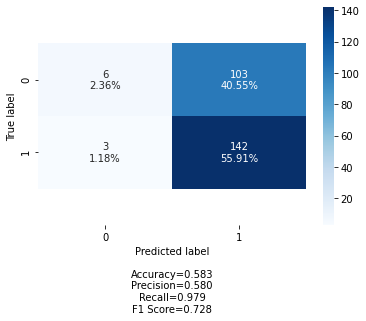

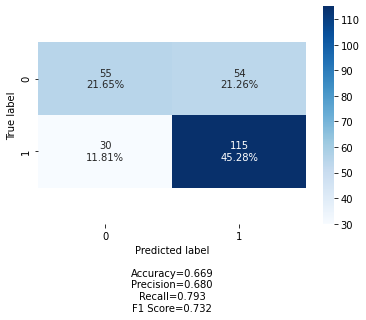

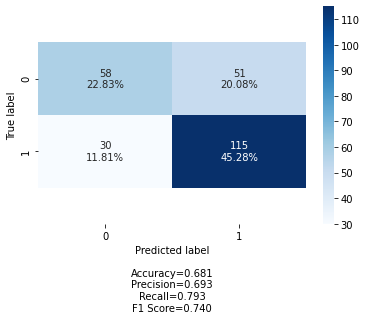

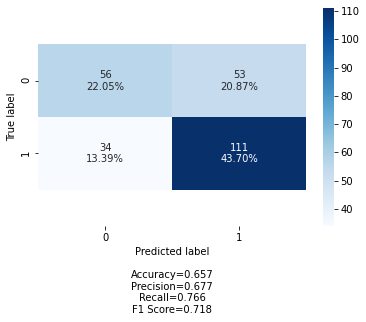

In [202]:
for i in range(4):
# Train a SVC model using different kernal
    svclassifier = getClassifier(i) 
    svclassifier.fit(scaled_x_train, y_train)
# Make prediction
    y_pred = svclassifier.predict(scaled_x_val)
    probs = svclassifier.predict_proba(scaled_x_val) 
# Evaluate our model
    cf = confusion_matrix(y_val,y_pred)
    make_confusion_matrix(cf,model=kernels[i], y_true=y_val,y_proba = probs[:,1])

In [ ]:
# sigmoid is the best

In [337]:
svc_grid = {'C': [0.1,1, 10, 100],
           'gamma': [1,0.1,0.01,0.001],
           'kernel': ['rbf', 'sigmoid', 'linear']}

In [338]:
# GRID SEARCH WHILE PRESERVING TIME SERIES CHRONOLOGY

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_no15):    
    X_tr, X_val = X_no15.iloc[tr_index], X_no15.iloc[val_index]
    y_tr, y_val = y_no15.iloc[tr_index], y_no15.iloc[val_index]
    
    scaler = StandardScaler()
    scaled_X_tr = scaler.fit_transform(X_tr)
    scaled_X_val = scaler.transform(X_val)
    
    for c in svc_grid['C']:
        for gamma in svc_grid['gamma']:
            for kernel in svc_grid['kernel']:
                model = SVC(probability=True)
                C=c, 
                gamma = gamma
                kernel = kernel
                model.fit(scaled_X_tr, y_tr)
                preds = model.predict(scaled_X_val)
                probs = model.predict_proba(scaled_X_val)
                score.append([i,
                              c,
                              gamma,
                              kernel, 
                              model.score(scaled_X_val, y_val),
                             f1_score(y_val, preds),
                             log_loss(y_val, probs[:,1]),
                             roc_auc_score(y_val, probs[:,1])])
    i += 1

In [339]:
score_SVC = pd.DataFrame(score, columns=['iter', 'C','gamma','kernel','accuracy', 'F1','log_loss', 'ROC-AUC'])

In [348]:
score_SVC.sort_values('log_loss', ascending=True)

,iter,C,gamma,kernel,accuracy,F1,log_loss,ROC-AUC
198,5,0.1,0.010,rbf,0.680,0.772727,0.621961,0.618194
237,5,100.0,0.001,rbf,0.680,0.772727,0.622351,0.617816
229,5,100.0,1.000,sigmoid,0.680,0.772727,0.622722,0.618308
204,5,1.0,1.000,rbf,0.680,0.772727,0.622771,0.618270
209,5,1.0,0.100,linear,0.680,0.772727,0.622848,0.618421
...,...,...,...,...,...,...,...,...
52,2,0.1,0.100,sigmoid,0.376,0.227723,0.809878,0.524354
89,2,100.0,0.100,linear,0.376,0.227723,0.810931,0.524318
72,2,10.0,1.000,rbf,0.376,0.227723,0.811025,0.524318
85,2,100.0,1.000,sigmoid,0.376,0.227723,0.811710,0.524318


In [345]:
svc_best_params = dict(score_SVC.iloc[144])
svc_best_params['probability'] = True

In [346]:
svc_best_params

{'iter': 4,
 'C': 0.1,
 'gamma': 1.0,
 'kernel': 'rbf',
 'accuracy': 0.712,
 'F1': 0.7906976744186046,
 'log_loss': 0.6252187673633864,
 'ROC-AUC': 0.6281305903398926,
 'probability': True}

{'model': None, 'accuracy': 0.609375, 'precision': 0.625, 'recall': 0.6884057971014492, 'f1': 0.6551724137931034, 'log_loss': 0.6564377854836478, 'ROC-AUC': 0.6569331859493982}


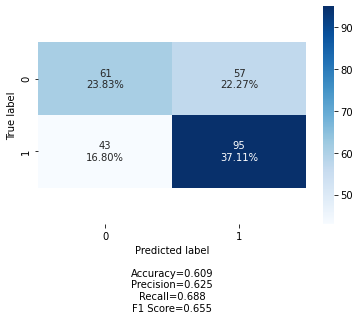

In [350]:
# FINAL TESTS AFTER TRAIN ON SCALED VAL (Did more experimenting after grid search)
final_ = SVC(C=100,kernel='rbf', gamma= .0001, probability=True)
final_.fit(scaled_x_train_2, y_no15)
preds = final_.predict(scaled_x_holdout)
probs = final_.predict_proba(scaled_x_holdout)

cm = confusion_matrix(y_holdout, preds)
make_confusion_matrix(cf = cm, y_true = y_holdout, y_proba=probs[:,1])

{'model': None, 'accuracy': 0.6484375, 'precision': 0.6481481481481481, 'recall': 0.7608695652173914, 'f1': 0.7000000000000001, 'log_loss': 0.6524686847854825, 'ROC-AUC': 0.6648243674772782}


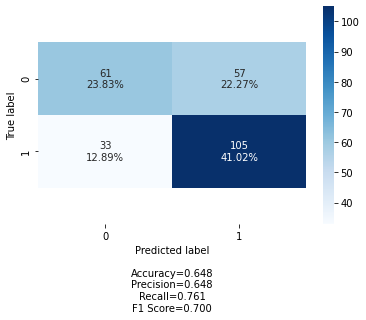

In [268]:
# BEST SVC
final_ = SVC(C=.0025,kernel='linear', gamma= 1, probability=True)
final_.fit(scaled_x_train_2, y_no15)
preds = final_.predict(scaled_x_holdout)
probs = final_.predict_proba(scaled_x_holdout)

cm = confusion_matrix(y_holdout, preds)
make_confusion_matrix(cf = cm, y_true = y_holdout, y_proba=probs[:,1])

# XGBoost

## baseline

In [45]:
import xgboost as xgb

{'model': 'XGB baseline', 'accuracy': 0.65748031496063, 'precision': 0.676829268292683, 'recall': 0.7655172413793103, 'f1': 0.7184466019417476, 'log_loss': 0.6219279267275193, 'ROC-AUC': 0.7074976273331225}


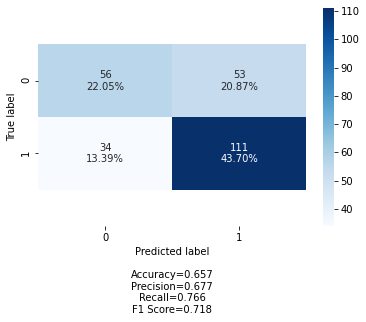

In [48]:
model = xgb.XGBClassifier()
model.fit(scaled_x_train, y_train)
preds = model.predict(scaled_x_val)
probas = model.predict_proba(scaled_x_val)

confusion_matrix(y_val, preds)
make_confusion_matrix(cf, model='XGB baseline', y_true=y_val, y_proba = probas[:,1])

In [311]:
# set up param dictionary for grid search
xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [318]:
# Grid search while preserving time series chronology

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_no15):    
    X_tr, X_val = X_no15.iloc[tr_index], X_no15.iloc[val_index]
    y_tr, y_val = y_no15.iloc[tr_index], y_no15.iloc[val_index]
    
    scaler = StandardScaler()
    scaled_X_tr = scaler.fit_transform(X_tr)
    scaled_X_val = scaler.transform(X_val)
    
    for mcw in xgb_params['min_child_weight']:
        for gamma in xgb_params['gamma']:
            for ss in xgb_params['subsample']:
                for cst in xgb_params['colsample_bytree']:
                    for md in xgb_params['max_depth']:
                        model = xgb.XGBClassifier()
                        min_child_weight=mcw, 
                        gamma = gamma
                        subsample = ss
                        colsample_bytree = cst
                        max_depth = md
                        
                        model.fit(scaled_X_tr, y_tr)
                        preds = model.predict(scaled_X_val)
                        probs = model.predict_proba(scaled_X_val)
                        score.append([i,
                                      mcw,
                                      gamma,
                                      ss, 
                                      cst,
                                      md,
                                      model.score(scaled_X_val, y_val),
                                     f1_score(y_val, preds),
                                     log_loss(y_val, probs[:,1]),
                                     roc_auc_score(y_val, probs[:,1])])
    i += 1

In [ ]:
score_XGB = pd.DataFrame(score, columns=['iter', 'min_child_weight',
                                         'gamma','subsample','colsample_bytree',
                                         'max_depth','accuracy', 'F1','log_loss', 'ROC-AUC'])

In [324]:
score_XGB.sort_values('log_loss', ascending=True)

,iter,min_child_weight,gamma,subsample,colsample_bytree,max_depth,accuracy,F1,log_loss,ROC-AUC
1518,4,10,1.0,0.6,1.0,3,0.688,0.767857,0.608351,0.691041
1489,4,10,0.5,0.6,0.8,4,0.688,0.767857,0.608351,0.691041
1488,4,10,0.5,0.6,0.8,3,0.688,0.767857,0.608351,0.691041
1487,4,10,0.5,0.6,0.6,5,0.688,0.767857,0.608351,0.691041
1486,4,10,0.5,0.6,0.6,4,0.688,0.767857,0.608351,0.691041
...,...,...,...,...,...,...,...,...,...,...
536,2,1,5.0,1.0,0.8,5,0.396,0.346320,1.016234,0.473432
535,2,1,5.0,1.0,0.8,4,0.396,0.346320,1.016234,0.473432
534,2,1,5.0,1.0,0.8,3,0.396,0.346320,1.016234,0.473432
544,2,5,0.5,0.6,0.8,4,0.396,0.346320,1.016234,0.473432


In [326]:
dict(score_XGB.iloc[1518])

{'iter': 4.0,
 'min_child_weight': 10.0,
 'gamma': 1.0,
 'subsample': 0.6,
 'colsample_bytree': 1.0,
 'max_depth': 3.0,
 'accuracy': 0.688,
 'F1': 0.7678571428571429,
 'log_loss': 0.6083513778820634,
 'ROC-AUC': 0.6910405485986882}

{'model': 'Final XGB test', 'accuracy': 0.5859375, 'precision': 0.6095890410958904, 'recall': 0.644927536231884, 'f1': 0.6267605633802816, 'log_loss': 0.6821958444124903, 'ROC-AUC': 0.6416728076639647}


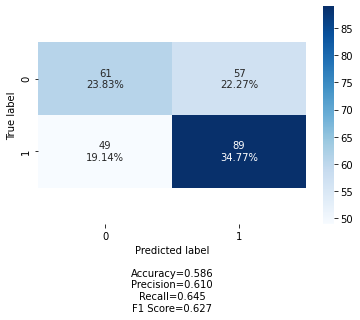

In [333]:
#final_xgb on test data

final_xgb = xgb.XGBClassifier(min_child_weight= 10.0,
                              gamma= 0.5,subsample= 0.6,
                              colsample_bytree= 1.0,
                              max_depth= 3)
final_xgb.fit(scaled_x_train_2, y_no15)
preds = final_xgb.predict(scaled_x_holdout)
probs = final_xgb.predict_proba(scaled_x_holdout)

cf = confusion_matrix(y_holdout, preds)
make_confusion_matrix(cf, model='Final XGB test', y_true = y_holdout, y_proba=probs[:,1])

In [ ]:
# AT THIS STAGE SVM APPEARS TO BE THE BEST MODEL